<a href="https://colab.research.google.com/github/rahiakela/deep-learning-for-nlp-by-jason-brownlee/blob/part-4-text-classi-cation/1_develop_embedding_cnn_model_for_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Develop an Embedding + CNN Model for Sentiment Analysis

Word embeddings are a technique for representing text where different words with similar meaning have a similar real-valued vector representation. They are a key breakthrough that has led to great performance of neural network models on a suite of challenging natural language processing problems.

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Movie Review Dataset

The Movie Review Data is a collection of movie reviews retrieved from the imdb.com website in the early 2000s by Bo Pang and Lillian Lee. The reviews were collected and made available as part of their research on natural language processing.

The dataset is comprised of 1,000 positive and 1,000 negative movie reviews drawn from an archive of the rec.arts.movies.reviews newsgroup hosted at IMDB. The authors refer to this dataset as the polarity dataset.

The data has been cleaned up somewhat, for example:
* The dataset is comprised of only English reviews.
* All text has been converted to lowercase.
* There is white space around punctuation like periods, commas, and brackets.
* Text has been split into one sentence per line.

The data has been used for a few related natural language processing tasks. For classification, the performance of classical models (such as Support Vector Machines) on the data is in the range of high 70% to low 80% (e.g. 78%-to-82%). More sophisticated data preparation may see results as high as 86% with 10-fold cross-validation.


After unzipping the file, you will have a directory called txt sentoken with two sub-directories containing the text neg and pos for negative and positive reviews. Reviews are stored
one per file with a naming convention from cv000 to cv999 for each of neg and pos.


## Load Text Data

we will look at loading individual text files, then processing the directories of filles. We will fetch data from Github repository where we have storred this Movie Review Polarity Dataset and after fetching it will be available in the current working directory in the folder txt sentoken.

We can load an individual text file by opening it, reading
in the ASCII text, and closing the file. This is standard file handling stuff.

In [0]:
# fetch dataset from github
! git clone https://github.com/rahiakela/machine-learning-datasets -b movie-review-polarity-dataset

Cloning into 'machine-learning-datasets'...
remote: Enumerating objects: 2010, done.
remote: Counting objects: 100% (2010/2010), done.
remote: Compressing objects: 100% (2009/2009), done.
remote: Total 2010 (delta 1), reused 2009 (delta 0), pack-reused 0
Receiving objects: 100% (2010/2010), 3.55 MiB | 19.35 MiB/s, done.
Resolving deltas: 100% (1/1), done.


## Data Preparation

In this section, we will look at 3 things:

1.   Separation of data into training and test sets.
2.   Loading and cleaning the data to remove punctuation and numbers.
3.   Defining a vocabulary of preferred words.



### Split into Train and Test Sets

We are pretending that we are developing a system that can predict the sentiment of a textual movie review as either positive or negative. This means that after the model is developed, we will need to make predictions on new textual reviews. This will require all of the same data preparation to be performed on those new reviews as is performed on the training data for the model.

We will ensure that this constraint is built into the evaluation of our models by splitting the training and test datasets prior to any data preparation. This means that any knowledge in the
test set that could help us better prepare the data (e.g. the words used) is unavailable during the preparation of data and the training of the model. 

That being said, we will use the last 100 positive reviews and the last 100 negative reviews as a test set (100 reviews) and the remaining 1,800 reviews as the training dataset. This is a 90% train, 10% split of the data. The split can be imposed easily by using the filenames of the reviews where reviews named 000 to 899 are for training data and reviews named 900 onwards are for testing the model.



### Loading and Cleaning Reviews

The text data is already pretty clean, so not much preparation is required. Without getting too much into the details, we will prepare the data using the following method:

* Split tokens on white space.
* Remove all punctuation from words.
* Remove all words that are not purely comprised of alphabetical characters.
* Remove all words that are known stop words.
* Remove all words that have a length <= 1 character.



In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords
import string
import re

# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()

  return text

# turn a doc into clean tokens
def clean_doc(doc):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return tokens

# define base path for dataset
base_path = 'machine-learning-datasets/movie-review-polarity-dataset/txt_sentoken'

# load one file
filename = base_path + '/pos/cv000_29590.txt'
text = load_doc(filename)

# clean doc
tokens = clean_doc(text)
print(tokens)

['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'theyre', 'superheroes', 'batman', 'superman', 'spawn', 'geared', 'toward', 'kids', 'casper', 'arthouse', 'crowd', 'ghost', 'world', 'theres', 'never', 'really', 'comic', 'book', 'like', 'hell', 'starters', 'created', 'alan', 'moore', 'eddie', 'campbell', 'brought', 'medium', 'whole', 'new', 'level', 'mid', 'series', 'called', 'watchmen', 'say', 'moore', 'campbell', 'thoroughly', 'researched', 'subject', 'jack', 'ripper', 'would', 'like', 'saying', 'michael', 'jackson', 'starting', 'look', 'little', 'odd', 'book', 'graphic', 'novel', 'pages', 'long', 'includes', 'nearly', 'consist', 'nothing', 'footnotes', 'words', 'dont', 'dismiss', 'film', 'source', 'get', 'past', 'whole', 'comic', 'book', 'thing', 'might', 'find', 'another', 'stumbling', 'block', 'hells', 'directors', 'albert', 'allen', 'hughes', 'getting', 'hughes', 'brothers', 'direct', 'seems', 'almost', 'ludicrous', 'casting', 'carrot', 'top', 'well', 'anythi

### Define a Vocabulary

It is important to define a vocabulary of known words when using a bag-of-words model. The more words, the larger the representation of documents, therefore it is important to constrain the words to only those believed to be predictive. 

This is dificult to know beforehand and often it is important to test difierent hypotheses about how to construct a useful vocabulary. We have already seen how we can remove punctuation and numbers from the vocabulary in the previous section. We can repeat this for all documents and build a set of all known words.

We can develop a vocabulary as a Counter, which is a dictionary mapping of words and their count that allows us to easily update and query. Each document can be added to the counter and we can step over all of the reviews in the negative directory and then the positive directory.

```python
# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
  # load doc
  doc = load_doc(filename)
  # clean doc
  tokens = clean_doc(doc)
  # update counts
  vocab.update(tokens)

# load all docs in a directory
def process_docs(directory, vocab):
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # add doc to vocab
    add_doc_to_vocab(path, vocab)

from os import listdir
from collections import Counter

# define vocab
vocab = Counter()

# add all docs to vocab
process_docs(base_path + '/pos', vocab)
process_docs(base_path + '/neg', vocab)

# print the size of the vocab
print(len(vocab))

# print the top words in the vocab
print(vocab.most_common(50))
```

We can step through the vocabulary and remove all words that have a low occurrence, such as only being used once or twice in all reviews.
```python
# keep tokens with > 2 occurrence
min_occurane = 2
tokens = [k for k, c in vocab.items() if c > min_occurane]
print(len(tokens))
```

Finally, the vocabulary can be saved to a new file called vocab.txt that we can later load and use to filter movie reviews prior to encoding them for modeling.
```python
def save_list(lines, filename):
  # convert lines to a single blob of text
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')
```

In [0]:
from os import listdir
from collections import Counter

# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
  # load doc
  doc = load_doc(filename)
  # clean doc
  tokens = clean_doc(doc)
  # update counts
  vocab.update(tokens)

# load all docs in a directory
def process_docs(directory, vocab):
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # add doc to vocab
    add_doc_to_vocab(path, vocab)

# save list to file
def save_list(lines, filename):
  # convert lines to a single blob of text
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

# define vocab
vocab = Counter()

# add all docs to vocab
process_docs(base_path + '/pos', vocab)
process_docs(base_path + '/neg', vocab)

# print the size of the vocab
print(len(vocab))

# print the top words in the vocab
print(vocab.most_common(50))

# keep tokens with > 2 occurrence
min_occurane = 2
tokens = [k for k, c in vocab.items() if c >= min_occurane]
print(len(tokens))

# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

44276
[('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511), ('make', 1418), ('really', 1407), ('little', 1351), ('life', 1334), ('plot', 1288), ('people', 1269), ('could', 1248), ('bad', 1248), ('scene', 1241), ('movies', 1238), ('never', 1201), ('best', 1179), ('new', 1140), ('scenes', 1135), ('man', 1131), ('many', 1130), ('doesnt', 1118), ('know', 1092), ('dont', 1086), ('hes', 1024), ('great', 1014), ('another', 992), ('action', 985), ('love', 977), ('us', 967), ('go', 952), ('director', 948), ('end', 946), ('something', 945), ('still', 936)]
25767


We are now ready to look at extracting features from the reviews ready for modeling.

## Train CNN With Embedding Layer

In this section, we will learn a word embedding while training a convolutional neural network on the classification problem. A word embedding is a way of representing text where each word in the vocabulary is represented by a real valued vector in a high-dimensional space. The vectors are learned in such a way that words that have similar meanings will have similar representation in the vector space (close in the vector space). This is a more expressive representation for text than more classical methods like bag-of-words, where relationships between words or tokens are ignored, or forced in bigram and trigram approaches.

The real valued vector representation for words can be learned while training the neural network. We can do this in the Keras deep learning library using the Embedding layer. The first step is to load the vocabulary. We will use it to filter out words from movie reviews that
we are not interested in.

So we have a local file called vocab.txt with one word per line. We can load that file and build a vocabulary as a set for checking the validity of tokens.

```python
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())
```

Next, we need to load all of the training data movie reviews. For that we can adapt the process docs() to load the documents, clean them, and return them as a list of strings, with one document per string. We want each document to be a string for easy encoding as a sequence of integers later. Cleaning the document involves splitting each review based on white space, removing punctuation, and then filtering out all tokens not in the vocabulary.

```python
# turn a doc into clean tokens
def clean_doc(doc, vocab):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # filter out tokens not in vocab
  tokens = [w for w in tokens if w in vocab]
  tokens = ' '.join(tokens)
  return tokens

# load all docs in a directory
def process_docs(directory, vocab, is_train):
  documents = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # load the doc
    doc = load_doc(path)
    # clean doc
    tokens = clean_doc(doc, vocab)
    # add to list
    documents.append(tokens)
  return documents
```

We can call the process docs function for both the neg and pos directories and combine the reviews into a single train or test dataset. We also can define the class labels for the dataset.

```python
# load and clean a dataset
def load_clean_dataset(vocab):
  # load documents
  neg = process_docs(base_path + '/neg', vocab)
  pos = process_docs(base_path + '/pos', vocab)

  docs = neg + pos

  # prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
  return docs, labels
```




### Movie Reviews to Bag-of-Words Vectors

We will use the Keras API to convert reviews to encoded document vectors. Keras provides the Tokenizer class that can do some of the cleaning and vocab definition tasks.It is better to do this ourselves to know exactly what was done and why. 

Nevertheless, the Tokenizer class is convenient and will easily transform documents into encoded vectors. First, the Tokenizer must be created, then fit on the text documents in the training dataset. In this case, these are the aggregation of the positive lines and negative lines arrays.

```python
# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer
```

This process determines a consistent way to convert the vocabulary to a fixed-length vector with 25,768 elements, which is the total number of words in the vocabulary file vocab.txt.

Next, documents can then be encoded using the Tokenizer by calling texts to matrix(). The function takes both a list of documents to encode and an encoding mode, which is the method
used to score words in the document. Here we specify freq to score words based on their frequency in the document. This can be used to encode the loaded training and test data, for example.

```python
# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')
```
This encodes all of the positive and negative reviews in the training dataset.

```python
# load all docs in a directory
def process_docs(directory, vocab, is_train):
  lines = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip files that do not have the right extension
    if is_train and filename.startswith('cv9'):
      continue
    if is_train and not filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # load and clean the doc
    line = doc_to_line(path, vocab)
    # add to list
    lines.append(line)

  return lines
```

Similarly, the load clean dataset() dataset must be updated to load either train or test data.

```python
# load and clean a dataset
def load_clean_dataset(vocab, is_train):
  # load documents
  neg = process_docs(base_path + '/neg', vocab, is_train)
  pos = process_docs(base_path + '/pos', vocab, is_train)

  docs = neg + pos

  # prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
  return docs, labels
```


We can put all of this together in a single example.

In [0]:
from keras.preprocessing.text import Tokenizer

# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

# turn a doc into clean tokens
def clean_doc(doc):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return tokens

# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
  # load the doc
  doc = load_doc(filename)
  # clean doc
  tokens = clean_doc(doc)
  # filter by vocab
  tokens = [w for w in tokens if w in vocab]
  return ' '.join(tokens)

# load all docs in a directory
def process_docs(directory, vocab, is_train):
  lines = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip files that do not have the right extension
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # load and clean the doc
    line = doc_to_line(path, vocab)
    # add to list
    lines.append(line)

  return lines

# load and clean a dataset
def load_clean_dataset(vocab, is_train):
  # load documents
  neg = process_docs(base_path + '/neg', vocab, is_train)
  pos = process_docs(base_path + '/pos', vocab, is_train)

  docs = neg + pos

  # prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
  return docs, labels

# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
print(len(train_docs))

# create the tokenizer
tokenizer = create_tokenizer(train_docs)

# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')
print(Xtrain.shape, Xtest.shape)

Using TensorFlow backend.


1800
(1800, 25768) (200, 25768)


The shape of the encoded training dataset and test dataset
with 1,800 and 200 documents respectively, each with the same sized encoding vocabulary (vector length).

## Sentiment Analysis Models

we will develop Multilayer Perceptron (MLP) models to classify encoded documents as either positive or negative. The models will be simple feedforward network models with fully connected layers called Dense in the Keras deep learning library. This section is divided into 3 sections:


1.   First sentiment analysis model
2.   Comparing word scoring modes
3.   Making a prediction for new reviews



### First Sentiment Analysis Model

We can develop a simple MLP model to predict the sentiment of encoded reviews. The model will have an input layer that equals the number of words in the vocabulary, and in turn the length of the input documents. We can store this in a new variable called n words, as follows:

```python
n_words = Xtest.shape[1]
```

We can now define the network. All model configuration was found with very little trial and error and should not be considered tuned for this problem. 

We will use a single hidden layer with 50 neurons and a rectified linear activation function. The output layer is a single neuron with a sigmoid activation function for predicting 0 for negative and 1 for positive reviews. 

The network will be trained using the efficient Adam implementation of gradient descent and thecbinary cross entropy loss function, suited to binary classification problems. We will keep track of accuracy when training and evaluating the model.

```python
# define the model
def define_model(n_words):
  # define network
  model = Sequential()
  model.add(Dense(50, input_shape=(n_words,), activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  plot_model(model, to_file='model.png', show_shapes=True)
  return model
```

Next, we can fit the model on the training data; in this case, the model is small and is easily fit in 10 epochs.

```python
# fit network
model.fit(Xtrain, ytrain, epochs=10, verbose=2)
```

Finally, once the model is trained, we can evaluate its performance by making predictions in the test dataset and printing the accuracy.

```python
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))
```

The complete example is listed below.

In [0]:
# define the model
def define_model(n_words):
  # define network
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(50, input_shape=(n_words, ), activation='relu'))
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # summarize defined model
  model.summary()

  # plot the model structure
  keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

  return model

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
print(len(train_docs))

# create the tokenizer
tokenizer = create_tokenizer(train_docs)

# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')
print(Xtrain.shape, Xtest.shape)

# define the model
print(Xtest.shape)
n_words = Xtest.shape[1]
model = define_model(n_words)

# ref: https://stackoverflow.com/questions/58682026/failed-to-find-data-adapter-that-can-handle-input-class-numpy-ndarray-cl
# convert array to numpy array
Xtrain = np.array(Xtrain)
ytrain = np.array(ytrain)
Xtest = np.array(Xtest)
ytest = np.array(ytest)

# fit the model
history = model.fit(Xtrain, ytrain, epochs=10, verbose=2)

# evaluate the model 
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print(f'Test Accuracy: {str(acc * 100)}')

1800
(1800, 25768) (200, 25768)
(200, 25768)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1288450   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
Train on 1800 samples
Epoch 1/10
1800/1800 - 2s - loss: 0.6916 - accuracy: 0.5583
Epoch 2/10
1800/1800 - 1s - loss: 0.6832 - accuracy: 0.6356
Epoch 3/10
1800/1800 - 1s - loss: 0.6671 - accuracy: 0.8694
Epoch 4/10
1800/1800 - 1s - loss: 0.6429 - accuracy: 0.8722
Epoch 5/10
1800/1800 - 1s - loss: 0.6108 - accuracy: 0.9039
Epoch 6/10
1800/1800 - 1s - loss: 0.5710 - accuracy: 0.9400
Epoch 7/10
1800/1800 - 1s - loss: 0.5286 - accuracy: 0.9483
Epoch 8/10
1800/1800 

We can see that the model easily fits the training data within the 10 epochs, achieving close to 100% accuracy. Evaluating the model on the test dataset, we can see that model does well,
achieving an accuracy of above 87%, well within the ballpark of low-to-mid 80s seen in the original paper. Although, it is important to note that this is not an apples-to-apples comparison, as the original paper used 10-fold cross-validation to estimate model skill instead of a single train/test split.

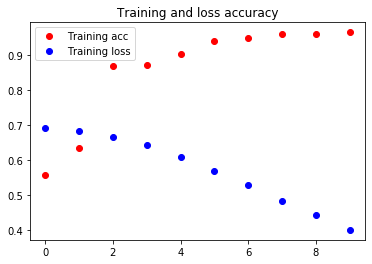

<Figure size 432x288 with 0 Axes>

In [0]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training and loss accuracy')
plt.legend()
plt.figure()

plt.show()

### Comparing Word Scoring Methods

The texts to matrix() function for the Tokenizer in the Keras API provides 4 different methods for scoring words; they are:

* **binary**:Where words are marked as present (1) or absent (0).
* **count**:Where the occurrence count for each word is marked as an integer.
* **tfidf**:Where each word is scored based on their frequency, where words that are common across all documents are penalized.
* **freq**:Where words are scored based on their frequency of occurrence within the document.

We can evaluate the skill of the model developed in the previous section fit using each of the 4 supported word scoring modes. This first involves the development of a function to create an
encoding of the loaded documents based on a chosen scoring model. The function creates the tokenizer, fits it on the training documents, then creates the train and test encodings using the chosen model.

```python
# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
  # create the tokenizer
  tokenizer = Tokenizer()
  # fit the tokenizer on the documents
  tokenizer.fit_on_texts(train_docs)
  # encode training data set
  Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
  # encode training data set
  Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
  return Xtrain, Xtest
```

We also need a function to evaluate the MLP given a specific encoding of the data. Because neural networks are stochastic, they can produce different results when the same model is fit on
the same data. This is mainly because of the random initial weights and the shuffling of patterns during mini-batch gradient descent. This means that any one scoring of a model is unreliable
and we should estimate model skill based on an average of multiple runs.

```python
# evaluate a neural network model
def evaluate_model(Xtrain, ytrain, Xtest, ytest):
  scores = list()
  n_repeats = 30
  n_words = Xtest.shape[1]
  for i in range(n_repeats):
  # define network
  model = Sequential()
  model.add(Dense(50, input_shape=(n_words,), activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit network
  model.fit(Xtrain, ytrain, epochs=10, verbose=2)
  # evaluate
  loss, acc = model.evaluate(Xtest, ytest, verbose=0)
  scores.append(acc)
  print('%d accuracy: %s' % ((i+1), acc))
  return scores
```

Pulling all of this together, the complete example is listed below.

(1800, 25768) (200, 25768)
(1800, 25768) (200, 25768)
(200, 25768)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 50)                1288450   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
1 accuracy: 0.92
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                1288450   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable para

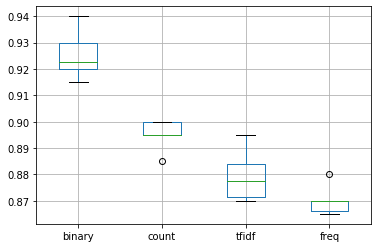

In [0]:
from pandas import DataFrame

# evaluate a neural network model
def evaluate_model(Xtrain, ytrain, Xtest, ytest):
  scores = list()
  n_repeats = 10
  print(Xtest.shape)
  n_words = Xtest.shape[1]

  for i in range(n_repeats):
    # define network
    model = define_model(n_words)
    # fit network
    model.fit(Xtrain, ytrain, epochs=10, verbose=0)
    # evaluate the model
    _, acc = model.evaluate(Xtest, ytest, verbose=0)
    scores.append(acc)
    print(f'{str(i + 1)} accuracy: {str(acc)}')
  return scores

# prepare bag of words encoding of docs
def prepare_data(train_docs, test_docs, mode):
  # create the tokenizer
  tokenizer = Tokenizer()
  # fit the tokenizer on the documents
  tokenizer.fit_on_texts(train_docs)
  # encode training data set
  Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
  # encode test data set
  Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
  
  return Xtrain, Xtest

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
# convert array to numpy array
ytrain = np.array(ytrain)
ytest = np.array(ytest)

# run experiment
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
  # prepare data for mode
  Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
  print(Xtrain.shape, Xtest.shape)
  # convert array to numpy array
  Xtrain = np.array(Xtrain)
  Xtest = np.array(Xtest)
  print(Xtrain.shape, Xtest.shape)
  # evaluate model on data for mode
  results[mode] = evaluate_model(Xtrain, ytrain, Xtest, ytest)

# summarize results
print(results.describe())

# plot results
results.boxplot()
plt.show()

At the end of the run, summary statistics for each word scoring method are provided, summarizing the distribution of model skill scores across each of the 10 runs per mode. 

We can see that the mean score of both the count and binary methods appear to be better than freq and tfidf.

A box and whisker plot of the results is also presented, summarizing the accuracy distributions per configuration. We can see that binary achieved the best results with a modest spread and might be the preferred approach for this dataset.

## Predicting Sentiment for New Reviews

Finally, we can develop and use a final model to make predictions for new textual reviews. This is why we wanted the model in the first place. First we will train a final model on all of the available data. We will use the binary mode for scoring the bag-of-words model that was shown to give the best results in the previous section.

Predicting the sentiment of new reviews involves following the same steps used to prepare the test data. Specifically, loading the text, cleaning the document, filtering tokens by the
chosen vocabulary, converting the remaining tokens to a line, encoding it using the Tokenizer, and making a prediction. We can make a prediction of a class value directly with the fit model
by calling predict() that will return an integer of 0 for a negative review and 1 for a positive review.

```python
# classify a review as negative or positive
def predict_sentiment(review, vocab, tokenizer, model):
  # clean
  tokens = clean_doc(review)
  # filter by vocab
  tokens = [w for w in tokens if w in vocab]
  # convert to line
  line = ' '.join(tokens)
  # encode
  encoded = tokenizer.texts_to_matrix([line], mode='binary')
  # predict sentiment
  yhat = model.predict(encoded, verbose=0)
  # retrieve predicted percentage and label
  percent_pos = yhat[0,0]
  if round(percent_pos) == 0:
    return (1-percent_pos), 'NEGATIVE'
  return percent_pos, 'POSITIVE'
```

We can now make predictions for new review texts. Below is an example with both a clearly positive and a clearly negative review using the simple MLP developed above with the frequency
word scoring mode.

```python
# test positive text
text = 'Best movie ever! It was great, I recommend it.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))
# test negative text
text = 'This is a bad movie.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))
```

Pulling this all together, the complete example for making predictions for new reviews.

In [0]:
# load all docs in a directory
def process_docs(directory, vocab):
  lines = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # create the full path of the file to open
    path = directory + '/' + filename
    # load and clean the doc
    line = doc_to_line(path, vocab)
    # add to list
    lines.append(line)
  return lines

# load and clean a dataset
def load_clean_dataset(vocab):
  # load documents
  neg = process_docs(base_path + '/neg', vocab)
  pos = process_docs(base_path + '/pos', vocab)
  docs = neg + pos
  # prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
  return docs, labels

# classify a review as negative or positive
def predict_sentiment(review, vocab, tokenizer, model):
  # clean doc
  tokens = clean_doc(review)
  # filter by vocab
  tokens = [w for w in tokens if w in vocab]
  # convert to line
  line = ' '.join(tokens)
  # encode 
  encoded = tokenizer.texts_to_matrix([line], mode='binary')
  # predict sentiment
  yhat = model.predict(encoded, verbose=0)
  # retrieve predicted percentage and label
  percent_pos = yhat[0, 0]
  if round(percent_pos) == 0:
    return (1 - percent_pos), 'NEGATIVE'
  return percent_pos, 'POSITIVE'

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

# load all reviews
train_docs, ytrain = load_clean_dataset(vocab)
test_docs, ytest = load_clean_dataset(vocab)
print(len(train_docs))

# create the tokenizer
tokenizer = create_tokenizer(train_docs)

# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='binary')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='binary')
print(Xtrain.shape, Xtest.shape)

# define the model
print(Xtest.shape)
n_words = Xtest.shape[1]
model = define_model(n_words)

# https://stackoverflow.com/questions/58682026/failed-to-find-data-adapter-that-can-handle-input-class-numpy-ndarray-cl
# convert array to numpy array
Xtrain = np.array(Xtrain)
ytrain = np.array(ytrain)
Xtest = np.array(Xtest)
ytest = np.array(ytest)

# fit the model
history = model.fit(Xtrain, ytrain, epochs=10, verbose=2)

# test positive text
text = 'Best movie ever! It was great, I recommend it.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print(f'Review: {text}\n Sentiment: {sentiment} {str(percent * 100)}')

# test negative text
text = 'This is a bad movie.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print(f'Review: {text}\n Sentiment: {sentiment} {str(percent * 100)}')

2000
(2000, 25768) (2000, 25768)
(2000, 25768)
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 50)                1288450   
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples
Epoch 1/10
2000/2000 - 1s - loss: 0.4806 - accuracy: 0.7685
Epoch 2/10
2000/2000 - 1s - loss: 0.0654 - accuracy: 0.9920
Epoch 3/10
2000/2000 - 1s - loss: 0.0171 - accuracy: 1.0000
Epoch 4/10
2000/2000 - 1s - loss: 0.0080 - accuracy: 1.0000
Epoch 5/10
2000/2000 - 1s - loss: 0.0046 - accuracy: 1.0000
Epoch 6/10
2000/2000 - 1s - loss: 0.0028 - accuracy: 1.0000
Epoch 7/10
2000/2000 - 1s - loss: 0.0017 - accuracy: 1.0000
Epoch 8/10
2000/

Ideally, we would fit the model on all available data (train and test) to create a final model and save the model and tokenizer to file so that they can be loaded and used in new software.

## Extensions

1- **Tune the Network Topology**. Explore alternate network topologies such as deeper or wider networks. Perhaps you can get better performance with a more suited network.

2- **Use Regularization.** Explore the use of regularization techniques, such as dropout.Perhaps you can delay the convergence of the model and achieve better test set performance.

3- **Training Diagnostics.** Use the test dataset as a validation dataset during training and create plots of train and test loss. Use these diagnostics to tune the batch size and number of training epochs.

4- **Use Bigrams.** Prepare the model to score bigrams of words and evaluate the performance under different scoring schemes.

